# Wasserstein GAN with Gradient Penalty (WGAN-GP)
In this notebook, we're going to build a [Wasserstein GAN with Gradient Penalty (WGAN-GP)](https://arxiv.org/pdf/1704.00028) that solves some of the stability issues with the GANs. Specifically, we'll use a special kind of loss function known as Wasserstein loss, and gradient penalties to prevent mode collapse.

# Importing Our Toolkit.

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Defining Visualization Functions.

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes,
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

## Building the Generator (DC-GAN).

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

# Generate The Noise Vector.

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Building the Critii
in WGAN-GP, we no longer use a discriminator that classifies fake or real as 0 or 1 but rather a critic that scores images with real numbers.

In [ ]:
class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

# Loading Our Dataset.

In [ ]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader( MNIST('.', download=True, transform=transform), batch_size= batch_size, shuffle=True)

## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section



In [ ]:
n_epochs = 100
z_dim = 64
display_step = 2500
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

## Generator, Critic, and Optimizers Initialization.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

## Weight Intialization.

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

# Gradient Penalty
Calculating the gradient penalty can be broken into 2 functions:
1.   Compute the gradient with respect to the images.
2.   Compute the gradient penalty given the gradient.

The gradient is computed by 1st creating a mixed image (adding them together to get intermediate images), and this is done by interpolation between the fake and real image using epsilon. Then get the critic's output on the image. Finally, compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input).

In [ ]:
# 1- Mix the images together
# 2- Calculate the critic's scores on the mixed images
# 3- Take the gradient of the scores with respect to the images
# 4- take the gradient of outputs with respect to inputs.
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images, outputs=mixed_scores, grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True, retain_graph=True )[0]
    return gradient


The 2nd  function is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

In [ ]:
# 1- Flatten the gradients so that each row captures one image
# 2- Calculate the magnitude of every row
# 3- Penalize the mean squared distance of the gradient norms from 1
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

## Loss Functions.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images.

In [ ]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp #gp > gradient_panelty(get_gradient())
    return crit_loss

## Putting It All Together
Before you put everything together, there are a few things to note.
1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using).
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 36.796834074765115, critic loss: -329.30392355055625


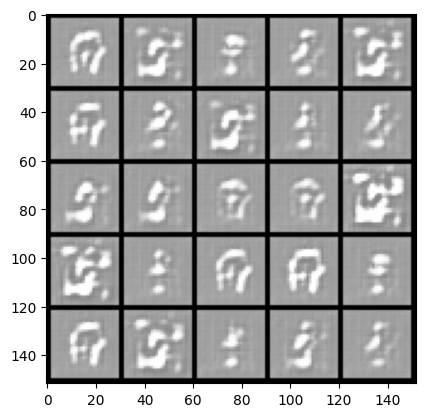

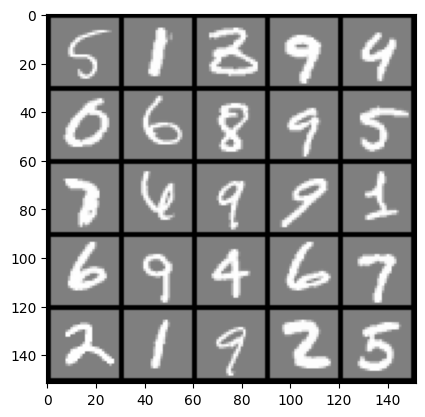

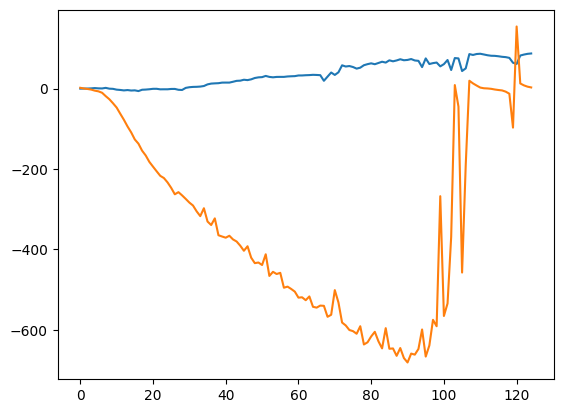

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 91.22451277160644, critic loss: -0.5087274507904054


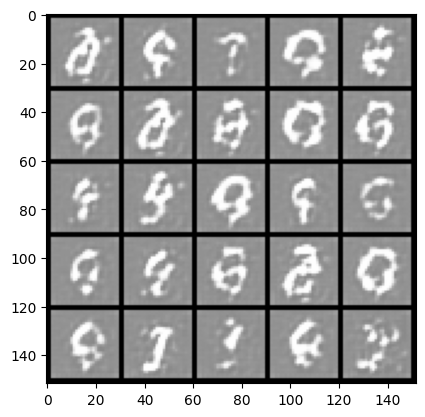

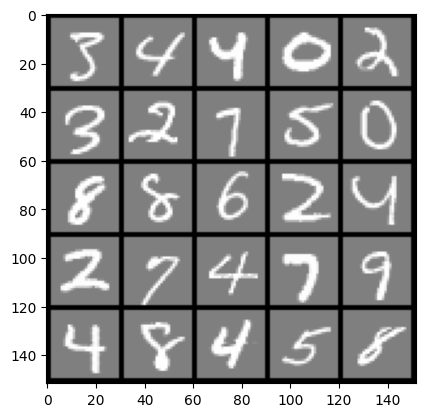

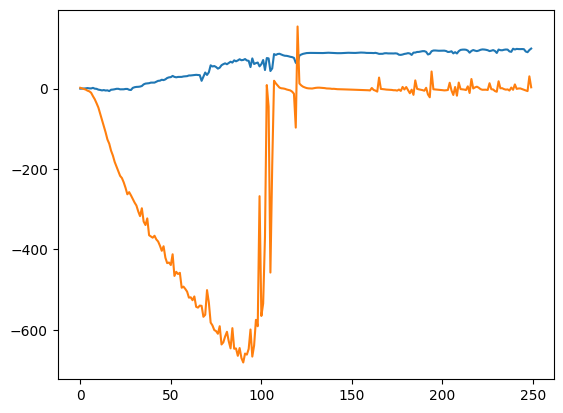

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 105.14194636535645, critic loss: 1.4077056725549686


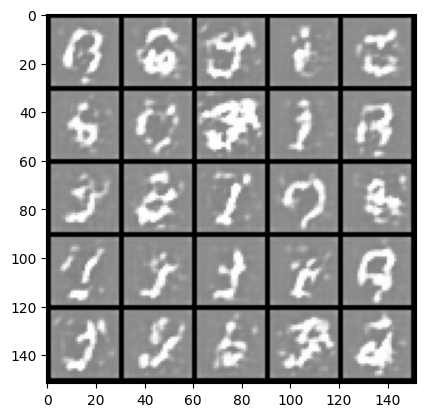

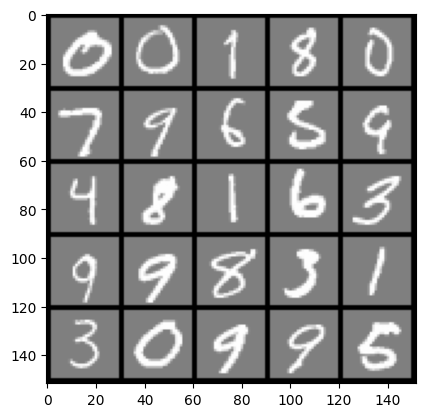

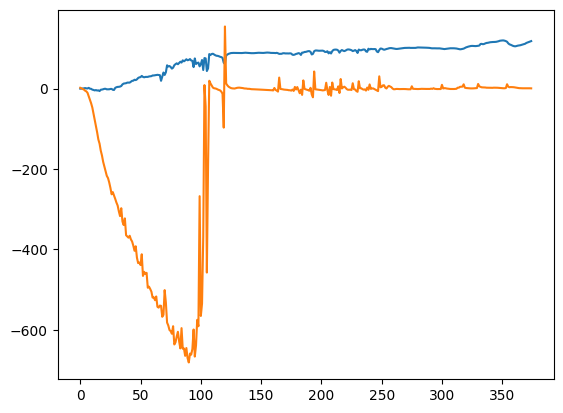

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 138.76249252929688, critic loss: 0.25685516990780793


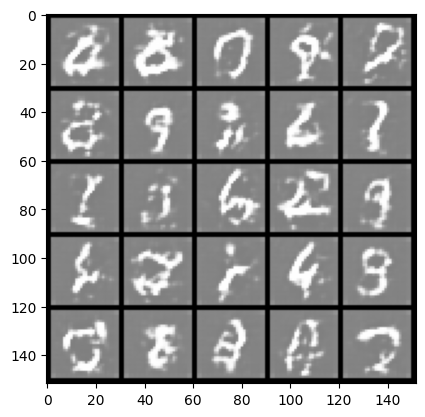

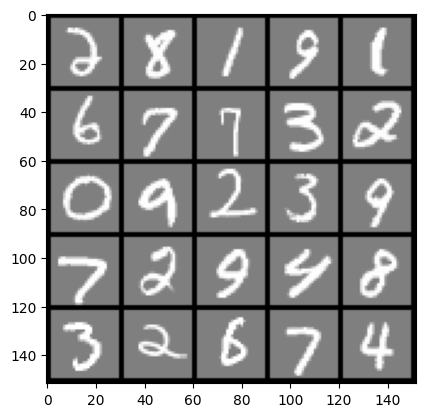

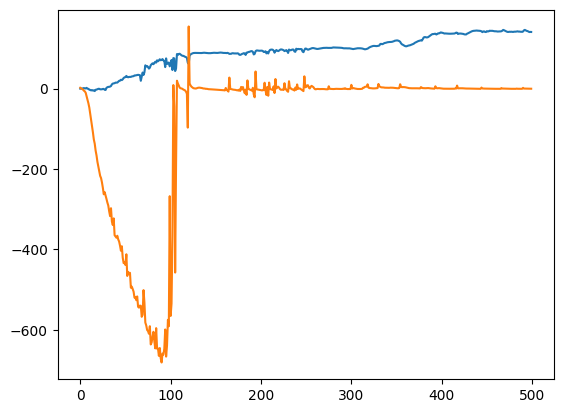

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss" )
            plt.show()

        cur_step += 1
